# Market Basket Analysis with PySpark and Apriori algorithm 

In [3]:

pip install pyspark


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install findspark

Note: you may need to restart the kernel to use updated packages.


In [283]:
%env SPARK_LOCAL_HOSTNAME=localhost
import findspark
findspark.init

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *
import numpy as np

spark = SparkSession.builder.config("spark.driver.host", "localhost").getOrCreate()
spark = SparkSession.Builder().appName('Project').getOrCreate()
sqlCtx = SQLContext(spark)


env: SPARK_LOCAL_HOSTNAME=localhost


C:\Users\rituk\anaconda3\lib\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### The first line %env SPARK_LOCAL_HOSTNAME=localhost is setting an environment variable SPARK_LOCAL_HOSTNAME to localhost, which specifies the hostname or IP address that the Spark driver should bind to.

### We have imported all the necessery libraries that we needed in the assignment. Also we have generated a spark session using the SparkSession library. After that we have created a project in a session to work on a assignment 


## Data preparation

### We have created df_market dataframe. In the below code inferSchema='true' specifies that the data types of each column should be inferred from the data itself.

In [284]:
df_market = spark.read.csv('Assignment-1_Data.csv', header='true', inferSchema='true', sep=';')


In [285]:
df_market.summary().show()


+-------+------------------+--------------------+------------------+----------------+------------------+------------------+-----------+
|summary|            BillNo|            Itemname|          Quantity|            Date|             Price|        CustomerID|    Country|
+-------+------------------+--------------------+------------------+----------------+------------------+------------------+-----------+
|  count|            522064|              520609|            522064|          522064|            522064|            388023|     522064|
|   mean| 559950.7852856276|                null|10.090435272303779|            null|15.576812289966394|15316.931710233672|       null|
| stddev|13452.750899836992|                null|161.11052518229036|            null|  72.6216939005565|1721.8469642664234|       null|
|    min|            536365|"ASSORTED FLOWER ...|             -9600|01.02.2011 08:23|         -11062,06|             12346|  Australia|
|    25%|          547892.0|                null

In [286]:
num_records = df_market.count()
print('Number of records: ', num_records)


Number of records:  522064


### FIlling CustomerID missing values with 99999

In [287]:
from pyspark.sql.functions import isnan, when, count, col
df_market.select([count(when(isnan(c), c)).alias(c) for c in df_market.columns]).show()

+------+--------+--------+----+-----+----------+-------+
|BillNo|Itemname|Quantity|Date|Price|CustomerID|Country|
+------+--------+--------+----+-----+----------+-------+
|     0|       0|       0|   0|    0|         0|      0|
+------+--------+--------+----+-----+----------+-------+



In [288]:
df_market = df_market.fillna(99999, subset='CustomerID')

In [289]:
summary = df_market.describe().toPandas()

In [290]:
summary

,summary,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,count,522064,520609,522064,522064,522064,522064,522064
1,mean,559950.7852856276,None,10.090435272303779,None,15.576812289966394,37059.22597995648,None
2,stddev,13452.750899836992,None,161.11052518229036,None,72.6216939005565,37022.44261731429,None
3,min,536365,"""ASSORTED FLOWER COLOUR """"LEIS""""""",-9600,01.02.2011 08:23,"-11062,06",12346,Australia
4,max,A563187,wrongly sold sets,80995,31.10.2011 17:19,"99,96",99999,Unspecified


In [291]:
df_market[['Itemname']].distinct().count()

4186

In [292]:
df_market[['Country']].distinct().show(100)

+--------------------+
|             Country|
+--------------------+
|              Sweden|
|             Germany|
|              France|
|             Belgium|
|               Italy|
|           Lithuania|
|              Norway|
|               Spain|
|             Iceland|
|              Israel|
|         Switzerland|
|               Japan|
|              Poland|
|            Portugal|
|           Australia|
|             Austria|
|             Bahrain|
|      United Kingdom|
|         Netherlands|
|           Singapore|
|              Greece|
|           Hong Kong|
|        Saudi Arabia|
|United Arab Emirates|
|             Lebanon|
|         Unspecified|
|                 USA|
|              Brazil|
|               Malta|
|                 RSA|
+--------------------+



In [293]:
df_market.filter(df_market.Itemname=='WHITE HANGING HEART T-LIGHT HOLDER').show(truncate=False)

+------+----------------------------------+--------+----------------+-----+----------+--------------+
|BillNo|Itemname                          |Quantity|Date            |Price|CustomerID|Country       |
+------+----------------------------------+--------+----------------+-----+----------+--------------+
|536365|WHITE HANGING HEART T-LIGHT HOLDER|6       |01.12.2010 08:26|2,55 |17850     |United Kingdom|
|536373|WHITE HANGING HEART T-LIGHT HOLDER|6       |01.12.2010 09:02|2,55 |17850     |United Kingdom|
|536375|WHITE HANGING HEART T-LIGHT HOLDER|6       |01.12.2010 09:32|2,55 |17850     |United Kingdom|
|536390|WHITE HANGING HEART T-LIGHT HOLDER|64      |01.12.2010 10:19|2,55 |17511     |United Kingdom|
|536394|WHITE HANGING HEART T-LIGHT HOLDER|32      |01.12.2010 10:39|2,55 |13408     |United Kingdom|
|536396|WHITE HANGING HEART T-LIGHT HOLDER|6       |01.12.2010 10:51|2,55 |17850     |United Kingdom|
|536401|WHITE HANGING HEART T-LIGHT HOLDER|4       |01.12.2010 11:21|2,95 |15862  

### The filter() method is used to select a subset of rows from a DataFrame that satisfy a particular condition. In this case, the condition is df_market.Itemname=='WHITE HANGING HEART T-LIGHT HOLDER', which means that we want to select only rows where the Itemname column is equal to the string 'WHITE HANGING HEART T-LIGHT HOLDER'.

### We see that the Price is referred to a single product

In [294]:
df_market = df_market.filter(df_market.Quantity>0)

In [295]:
df_market = df_market.dropna()

### The above line of code filters the df_market DataFrame to include only rows where the Quantity column is greater than 0 and we have removed those values from our data.

### We created a Total_Price column, equal to price x quantity, and we clean the other fields

In [296]:
df_market = df_market.withColumn('Price', regexp_replace('Price', ',', '.'))
df_market = df_market.withColumn('Total_Price', round(df_market.Price * df_market.Quantity, 2))
df_market = df_market.withColumn('Hour', split('Date', ' ')[1])
df_market = df_market.withColumn('Date', split('Date', ' ')[0])
df_market = df_market.withColumn( 'Date', concat_ws('-', split('Date', '\.')[2], split('Date', '\.')[1], split('Date', '\.')[0]))
df_market = df_market.withColumn('Date', to_date('Date'))
df_market.show()

+------+--------------------+--------+----------+-----+----------+--------------+-----------+-----+
|BillNo|            Itemname|Quantity|      Date|Price|CustomerID|       Country|Total_Price| Hour|
+------+--------------------+--------+----------+-----+----------+--------------+-----------+-----+
|536365|WHITE HANGING HEA...|       6|2010-12-01| 2.55|     17850|United Kingdom|       15.3|08:26|
|536365| WHITE METAL LANTERN|       6|2010-12-01| 3.39|     17850|United Kingdom|      20.34|08:26|
|536365|CREAM CUPID HEART...|       8|2010-12-01| 2.75|     17850|United Kingdom|       22.0|08:26|
|536365|KNITTED UNION FLA...|       6|2010-12-01| 3.39|     17850|United Kingdom|      20.34|08:26|
|536365|RED WOOLLY HOTTIE...|       6|2010-12-01| 3.39|     17850|United Kingdom|      20.34|08:26|
|536365|SET 7 BABUSHKA NE...|       2|2010-12-01| 7.65|     17850|United Kingdom|       15.3|08:26|
|536365|GLASS STAR FROSTE...|       6|2010-12-01| 4.25|     17850|United Kingdom|       25.5|08:26|


## We tried to check the total_price sum with the multiplication of price and quantity of items values and as we can see above it is matching.

In [299]:
from pyspark.sql.functions import col, round

# Add a column for the product of Quantity and Price
df_market_price = df_market.withColumn("Quantity_times_Price", col("Quantity") * col("Price"))

# Round the Total_Price and Quantity_times_Price columns to 2 decimal places
df_market_price = df_market_price.withColumn("Total_Price_rounded", round(col("Total_Price"), 2))
df_market_price = df_market_price.withColumn("Quantity_times_Price_rounded", round(col("Quantity_times_Price"), 2))

# Verify if Total_Price_rounded is equal to Quantity_times_Price_rounded
df_market_price = df_market_price.withColumn("Price_times_Quantity_equals_Total_Price", col("Total_Price_rounded") == col("Quantity_times_Price_rounded"))

# Select relevant columns
df_market_price = df_market_price.select("BillNo", "Quantity", "Price", "Total_Price_rounded", "Quantity_times_Price_rounded", "Price_times_Quantity_equals_Total_Price")

# Show the dataframe

df_market_price.show()



+------+--------+-----+-------------------+----------------------------+---------------------------------------+
|BillNo|Quantity|Price|Total_Price_rounded|Quantity_times_Price_rounded|Price_times_Quantity_equals_Total_Price|
+------+--------+-----+-------------------+----------------------------+---------------------------------------+
|536365|       6| 2.55|               15.3|                        15.3|                                   true|
|536365|       6| 3.39|              20.34|                       20.34|                                   true|
|536365|       8| 2.75|               22.0|                        22.0|                                   true|
|536365|       6| 3.39|              20.34|                       20.34|                                   true|
|536365|       6| 3.39|              20.34|                       20.34|                                   true|
|536365|       2| 7.65|               15.3|                        15.3|                        

In [300]:
count = df_market_price.count()
print("Number of rows:", count)


Number of rows: 520136


In [301]:
df_market

DataFrame[BillNo: string, Itemname: string, Quantity: int, Date: date, Price: string, CustomerID: int, Country: string, Total_Price: double, Hour: string]

## Data Analysis and Cleaning

### Outlier Detection we have used IQR method. After that we found around 42211 outliers in our dataset. So we decided to use flooring and capping mathod to remove the outliers with the upper or lower cap values.

In [302]:
from pyspark.sql.functions import col

quantiles = df_market.approxQuantile('Total_Price', [0.25, 0.75], 0.05)
q1 = quantiles[0]
q3 = quantiles[1]



In [303]:
iqr = q3 - q1


In [304]:
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr


In [305]:
outliers = df_market.filter((df_market.Total_Price < lower_bound) | (df_market.Total_Price > upper_bound))


In [306]:
outliers.show()
print("Total outliers ", outliers.count())

+------+--------------------+--------+----------+-----+----------+--------------+-----------+-----+
|BillNo|            Itemname|Quantity|      Date|Price|CustomerID|       Country|Total_Price| Hour|
+------+--------------------+--------+----------+-----+----------+--------------+-----------+-----+
|536367|ASSORTED COLOUR B...|      32|2010-12-01| 1.69|     13047|United Kingdom|      54.08|08:34|
|536370|ALARM CLOCK BAKEL...|      24|2010-12-01| 3.75|     12583|        France|       90.0|08:45|
|536370|ALARM CLOCK BAKEL...|      24|2010-12-01| 3.75|     12583|        France|       90.0|08:45|
|536370|ALARM CLOCK BAKEL...|      12|2010-12-01| 3.75|     12583|        France|       45.0|08:45|
|536370|INFLATABLE POLITI...|      48|2010-12-01| 0.85|     12583|        France|       40.8|08:45|
|536370|SET/2 RED RETROSP...|      18|2010-12-01| 2.95|     12583|        France|       53.1|08:45|
|536370|ROUND SNACK BOXES...|      24|2010-12-01| 2.95|     12583|        France|       70.8|08:45|


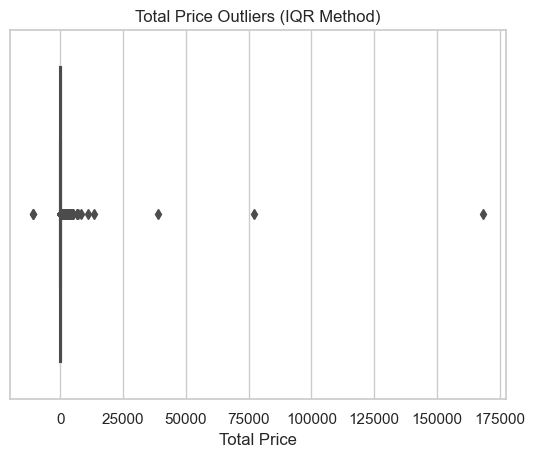

In [307]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the outliers_iqr DataFrame to a Pandas DataFrame
outliers_iqr_pd = outliers.select('Total_Price').toPandas()

# Create a box plot of the outlier values
sns.boxplot(x=outliers_iqr_pd['Total_Price'], orient='h')

# Set the plot title and axis labels
plt.title('Total Price Outliers (IQR Method)')
plt.xlabel('Total Price')

# Show the plot
plt.show()


In [308]:
quantiles = df_market.approxQuantile('Total_Price', [0.25, 0.75], 0.05)
q1 = quantiles[0]
q3 = quantiles[1]


In [309]:
iqr = q3 - q1


### if the data point is outside the range of (Q1 - 1.5 * IQR) to (Q3 + 1.5 * IQR) is considered an outlier.

In [310]:
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
print("The Lower bound of total_price is", lower_bound)
print("THe upper_bound of total_price is", upper_bound)

The Lower bound of total_price is -16.499999999999996
THe upper_bound of total_price is 36.3


### We created Total_Price_Floor_Cap which replaces the outliers with the nearest non-outlier value within the defined range.

In [321]:
df_market = df_market.withColumn('Total_Price_Floor_Cap', when(df_market.Total_Price < lower_bound, lower_bound).when(df_market.Total_Price > upper_bound, upper_bound).otherwise(df_market.Total_Price))


In [322]:
df_market.show()


+------+--------------------+--------+----------+-----+----------+--------------+-----------+-----+---------------------+
|BillNo|            Itemname|Quantity|      Date|Price|CustomerID|       Country|Total_Price| Hour|Total_Price_Floor_Cap|
+------+--------------------+--------+----------+-----+----------+--------------+-----------+-----+---------------------+
|536365|WHITE HANGING HEA...|       6|2010-12-01| 2.55|     17850|United Kingdom|       15.3|08:26|                 15.3|
|536365| WHITE METAL LANTERN|       6|2010-12-01| 3.39|     17850|United Kingdom|      20.34|08:26|                20.34|
|536365|CREAM CUPID HEART...|       8|2010-12-01| 2.75|     17850|United Kingdom|       22.0|08:26|                 22.0|
|536365|KNITTED UNION FLA...|       6|2010-12-01| 3.39|     17850|United Kingdom|      20.34|08:26|                20.34|
|536365|RED WOOLLY HOTTIE...|       6|2010-12-01| 3.39|     17850|United Kingdom|      20.34|08:26|                20.34|
|536365|SET 7 BABUSHKA N

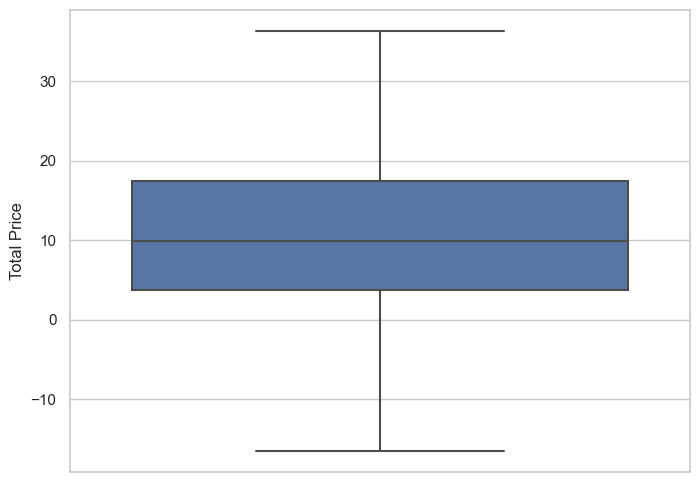

In [326]:
# Select the Total_Price column and convert it to a Pandas dataframe
total_price_pd = df_market.select('Total_Price_Floor_Cap').toPandas()

# Create a box plot using seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=total_price_pd, y='Total_Price_Floor_Cap')
plt.ylabel('Total Price')
plt.show()



## As we can see from above graph, the outliers were removed from the dataset 

## Now, We have completed the following things in our dataframe
## We have used SQL queries to group the data by country and item name and compute the total quantity and total price of each item in each country. The results are stored in a new DataFrame "itemname_by_country".
## We used another SQL query to find the top-selling product (based on quantity) in each country. The results are stored in a new DataFrame "top_product_country".
## Prints the top-selling products in each country in descending order of quantity.

In [327]:
#df_sql = sqlCtx.createDataFrame(df_market)
df_market.createOrReplaceTempView("df")
itemname_by_country = sqlCtx.sql("""SELECT Country, Itemname, SUM(Quantity) as Quantity, SUM(Total_Price) as Total_Price FROM df GROUP BY Country, Itemname""")
itemname_by_country.createOrReplaceTempView("itemname_by_country")

top_product_country = sqlCtx.sql("""SELECT Country, Itemname, Quantity FROM 
    (SELECT Country, Itemname, Quantity, MAX(Quantity) OVER(PARTITION BY Country) AS Max_Quant FROM itemname_by_country)
    WHERE Quantity=MAX_QUANT
    """)

print("Best sellers by country")
top_product_country.orderBy('Quantity', ascending=False).show(40, truncate=False)

Best sellers by country
+--------------------+-----------------------------------+--------+
|Country             |Itemname                           |Quantity|
+--------------------+-----------------------------------+--------+
|United Kingdom      |PAPER CRAFT , LITTLE BIRDIE        |80995   |
|Netherlands         |RABBIT NIGHT LIGHT                 |4801    |
|France              |RABBIT NIGHT LIGHT                 |4024    |
|Japan               |RABBIT NIGHT LIGHT                 |3408    |
|Australia           |MINI PAINT SET VINTAGE             |2952    |
|Sweden              |MINI PAINT SET VINTAGE             |2916    |
|Germany             |ROUND SNACK BOXES SET OF4 WOODLAND |1233    |
|Spain               |CHILDRENS CUTLERY POLKADOT PINK    |729     |
|Switzerland         |PLASTERS IN TIN WOODLAND ANIMALS   |639     |
|Norway              |SMALL FOLDING SCISSOR(POINTED EDGE)|576     |
|Belgium             |PACK OF 72 RETROSPOT CAKE CASES    |480     |
|Singapore           |CH

### In the below code, we are calculating the total revenue (Total_Price) earned by each country 

In [328]:
tot_price_by_country = sqlCtx.sql("""SELECT Country, ROUND(SUM(Total_Price), 2) AS Total_Price FROM itemname_by_country GROUP BY Country""")

print("Total gain by country")
tot_price_by_country_pd = tot_price_by_country.orderBy('Total_Price', ascending=False).toPandas()

tot_price_by_country_pd.head(40)

Total gain by country


,Country,Total_Price
0,United Kingdom,9003097.96
1,Netherlands,285446.34
2,Germany,228867.14
3,France,209715.11
4,Australia,138521.31
5,Spain,61577.11
6,Switzerland,57089.90
7,Belgium,41196.34
8,Sweden,38378.33
9,Japan,37416.37


## Visualization

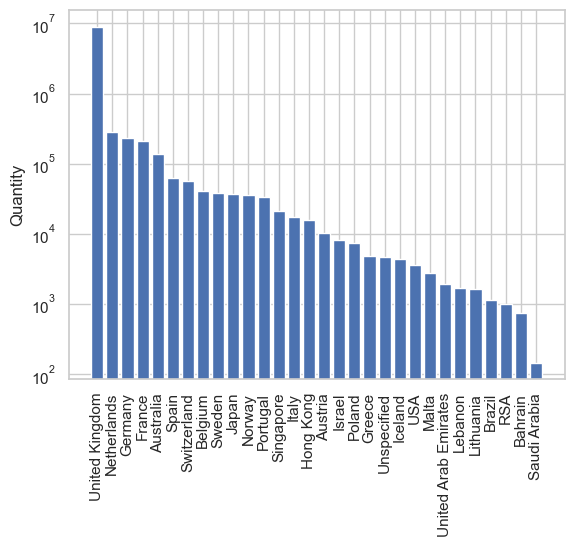

In [329]:

x = tot_price_by_country_pd['Country']
y = tot_price_by_country_pd['Total_Price']

plt.bar(x, y)
plt.yscale('log')
plt.ylabel('Quantity')
plt.xticks(rotation=90)
plt.show()

In [330]:
items_quantity = sqlCtx.sql("""SELECT Itemname, SUM(Quantity) as Quantity, SUM(Total_Price) as Total_Price FROM itemname_by_country GROUP BY Itemname""")
items_quantity_df = items_quantity.toPandas()

items_quantity_df = items_quantity_df.sort_values(by='Quantity', ascending=False)

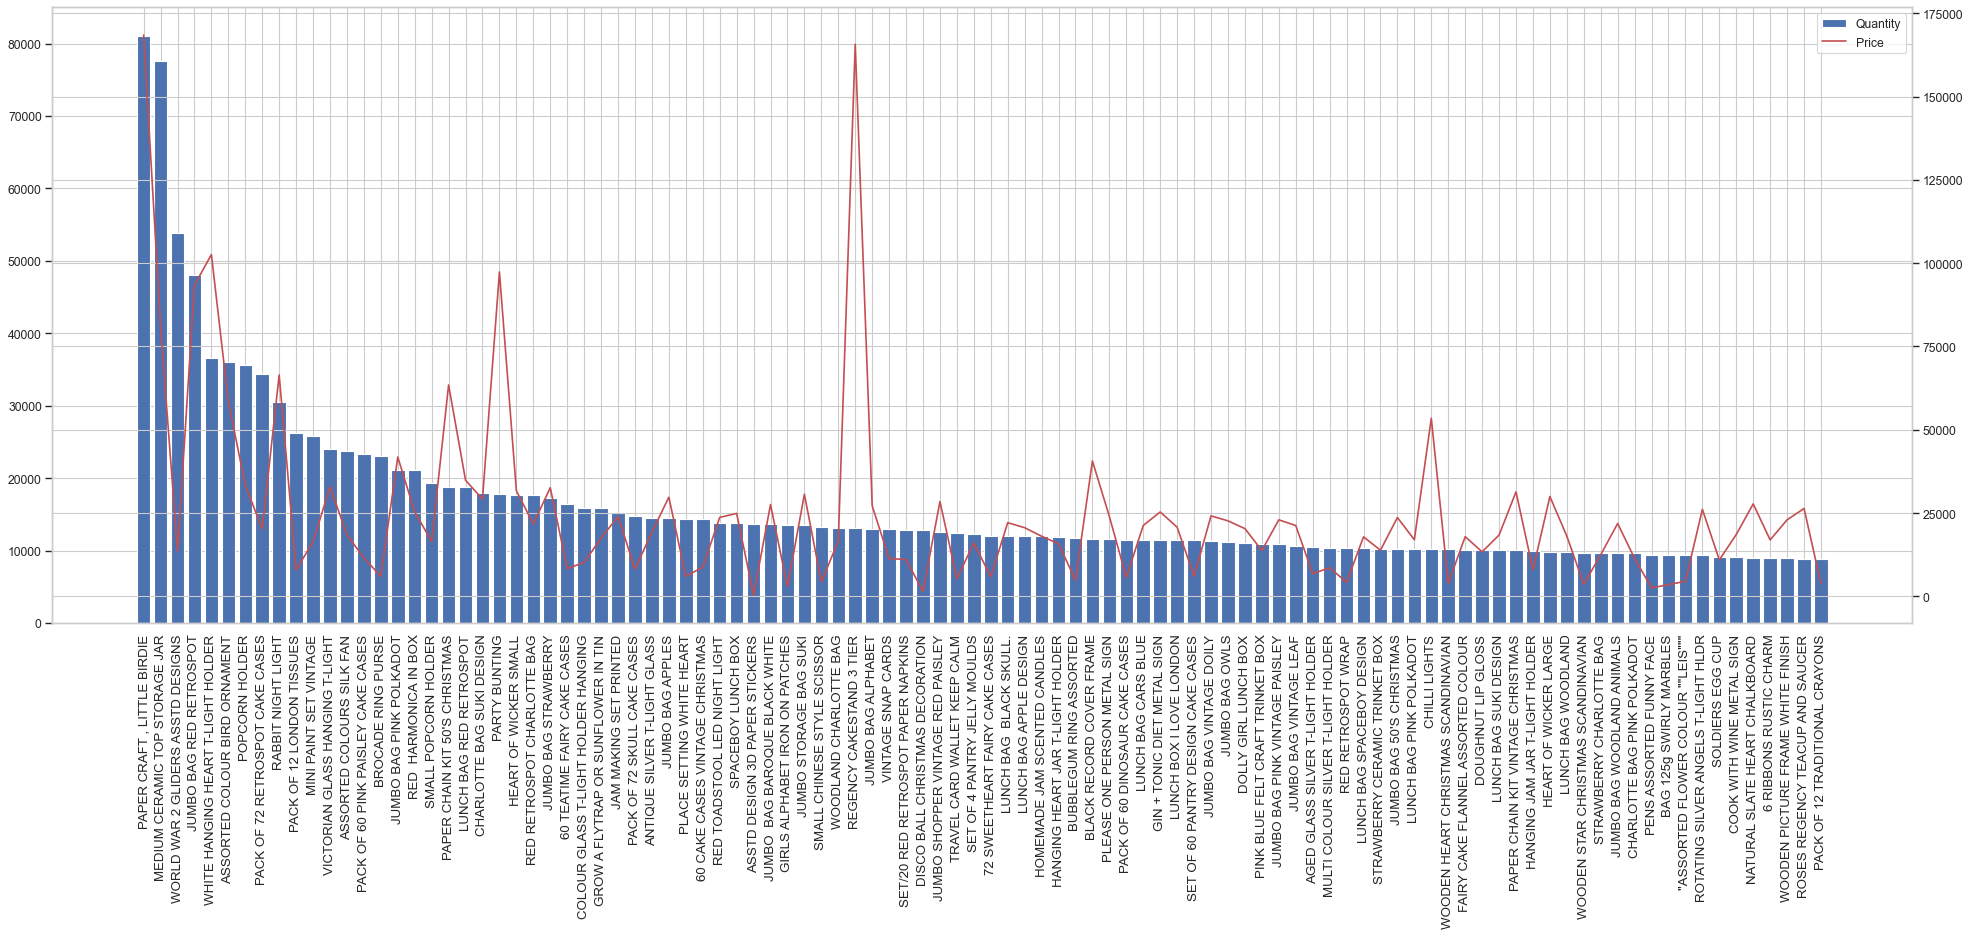

In [331]:
ntop = 100

x = items_quantity_df['Itemname'][:ntop]
quant = items_quantity_df['Quantity'][:ntop]
price = items_quantity_df['Total_Price'][:ntop]
plt.figure(figsize=(30, 10), dpi=80)

ax1 = plt.subplot()
l1 = ax1.bar(x, quant, label='Quantity')
plt.xticks(rotation=90, fontsize=12)

ax2 = ax1.twinx()
l2, = ax2.plot(x, price, label='Price', color='r')
plt.legend([l1, l2], ["Quantity", "Price"])
plt.show()



### The above chart represents the quantity of items sold (bars) and the total gain for each item. We can see that the items which give the more gain are not always the ones which are sold in large quantity. 

In [332]:
expense_per_customer = sqlCtx.sql("""SELECT CustomerID, Country, SUM(Total_Price) as Total_Price FROM df WHERE CustomerID <> 99999 GROUP BY CustomerID, Country""")
expense_per_customer_pd = expense_per_customer.toPandas()

In [333]:
expense_per_customer_pd.sort_values(by='Total_Price', ascending=False)

,CustomerID,Country,Total_Price
352,14646,Netherlands,280206.02
661,18102,United Kingdom,259657.30
785,17450,United Kingdom,194550.79
2505,16446,United Kingdom,168472.50
93,12415,Australia,124914.53
...,...,...,...
2252,17956,United Kingdom,12.75
3400,16454,United Kingdom,6.90
3606,14792,United Kingdom,6.20
1744,16738,United Kingdom,3.75


C:\Users\rituk\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


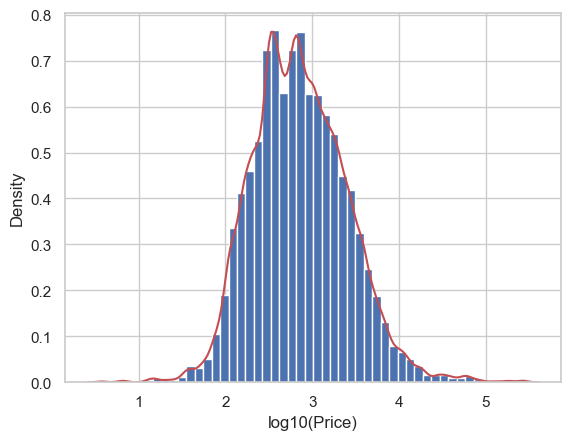

In [334]:
plt.hist(np.log10(expense_per_customer_pd['Total_Price'][expense_per_customer_pd['Total_Price']>0]), bins=50, density=True)
sns.kdeplot((np.log10(expense_per_customer_pd['Total_Price'][expense_per_customer_pd['Total_Price']>0])), bw=0.1, color='r')
plt.xlabel('log10(Price)')
plt.show()

## We note that the distribution of the expenses per customer is symmetrical, with two peeks, in a log scale. 

# Apriori Analysis

### We append in a list all items belonging to the same buy (i.e. the same bill).

### We have used the StringIndexer from PySpark's ML library to convert the Itemname column from categorical string values to numerical indices. Then, it selects the Country, BillNo, and Itemname columns from the original dataframe, removes duplicates, and groups by BillNo and Country. Finally, it uses the collect_list function to create a vector of unique Itemname values for each BillNo and Country combination.

### This code essentially creates a one-hot encoding of the Itemname column for each BillNo and Country combination.

In [335]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer, CountVectorizer
from pyspark.sql.types import IntegerType

indexer = StringIndexer(inputCol="Itemname", outputCol="ItemnameIndex")

df_group = indexer.fit(df_market).transform(df_market)

#df_group = df_group.withColumn("Itemname", df_group["ItemnameIndex"].cast(IntegerType()))

df_group = df_group[['Country', 'BillNo', 'Itemname']].distinct()

df_group = df_group.groupBy('BillNo', 'Country').agg(collect_list('Itemname').alias('Itemname_vec'))

df_group.show()


+------+--------------+--------------------+
|BillNo|       Country|        Itemname_vec|
+------+--------------+--------------------+
|536394|United Kingdom|[FANCY FONT BIRTH...|
|536402|United Kingdom|[HOT WATER BOTTLE...|
|536534|United Kingdom|[HAND WARMER SCOT...|
|536535|United Kingdom|[LOVEBIRD HANGING...|
|536575|United Kingdom|[JUMBO BAG RED RE...|
|536611|United Kingdom|[BATHROOM METAL S...|
|536628|United Kingdom|[CREAM CUPID HEAR...|
|536629|United Kingdom|[HAND WARMER RED ...|
|536741|United Kingdom|[6 RIBBONS RUSTIC...|
|536806|United Kingdom|[TOILET METAL SIG...|
|536838|United Kingdom|[FENG SHUI PILLAR...|
|536944|         Spain|[LUNCH BAG  BLACK...|
|536945|United Kingdom|[TOY TIDY SPACEBO...|
|536988|United Kingdom|[HOT WATER BOTTLE...|
|536992|United Kingdom|[CHARLIE + LOLA R...|
|537023|United Kingdom|[CHILLI LIGHTS, C...|
|537044|United Kingdom|[SET/3 OCEAN SCEN...|
|537051|United Kingdom|[WHITE HANGING HE...|
|537052|United Kingdom|[SET 3 RETROSPOT ...|
|537058|Un

In [336]:
countries = []
for country in df_market[['Country']].distinct().collect():
    countries.append(country['Country'])

### The following code will execute for every country an "apriori algorithm" and save the results in a dictionary. Due to limited resources, we computed the association rules only for a subset of countries.

### The minSupport and minConfidence parameters are set to 0.1 and 0.8, respectively, which means that the algorithm will find frequent itemsets that appear in at least 10% of the transactions, and generate association rules that have a confidence of at least 80%.

In [337]:
from pyspark.ml.fpm import FPGrowth
from time import time


minSupport=0.1
minConfidence=0.8
results = {}

#we take a subsample of countries
countries = ['Belgium', 'Germany', 'Italy', 'Netherlands', 'Portugal', 'Norway', 'Spain', 'Sweden', 'Australia' ]


for country in countries:

    print(country)
    fpGrowth = FPGrowth(itemsCol="Itemname_vec", minSupport=minSupport, minConfidence=minConfidence)
    model = fpGrowth.fit(df_group.filter(df_group['Country']==country))
    


   
    print('done')
    results[country] = model.associationRules
    

Belgium
done
Germany
done
Italy
done
Netherlands
done
Portugal
done
Norway
done
Spain
done
Sweden
done
Australia
done


In [338]:
from pyspark.sql.functions import lit
country = countries[0]
apriori = results[country].withColumn('country', lit(country))

for country in countries[1:5]:
    df_temp = results[country].withColumn('country', lit(country))
    apriori =  apriori.union(df_temp)
    

### We computed the number of countries in which a certain association rule is present, as well as the mean lift and the minimum lift for all countries. From the following table we can see that there are rules with a significative lift (lift>2) shared by 3/2 countries.


In [339]:
apriori.createOrReplaceTempView("apriori")
rules = sqlCtx.sql("""SELECT antecedent, consequent, COUNT(DISTINCT country) as n_country , ROUND(AVG(lift), 3) as mean_lift, ROUND(MIN(lift), 3) as min_lift FROM apriori GROUP BY antecedent, consequent""")
rules.sort(col('n_country').desc(), col('mean_lift').desc()).show(30, truncate=False)



+-----------------------------------------------------------------------+-------------------------------------+---------+---------+--------+
|antecedent                                                             |consequent                           |n_country|mean_lift|min_lift|
+-----------------------------------------------------------------------+-------------------------------------+---------+---------+--------+
|[ROUND SNACK BOXES SET OF 4 FRUITS]                                    |[ROUND SNACK BOXES SET OF4 WOODLAND] |3        |2.954    |2.11    |
|[REGENCY CAKESTAND 3 TIER]                                             |[POSTAGE]                            |3        |1.292    |1.021   |
|[PLASTERS IN TIN CIRCUS PARADE]                                        |[PLASTERS IN TIN WOODLAND ANIMALS]   |2        |6.274    |6.214   |
|[ROUND SNACK BOXES SET OF 4 FRUITS, POSTAGE]                           |[ROUND SNACK BOXES SET OF4 WOODLAND] |2        |2.791    |2.211   |
|[ROUND SNACK

### Now we apply the same algorithm to the whole dataset, considering a min support of 0.02 and a min confidence of 0.4.

In [340]:
from pyspark.ml.fpm import FPGrowth
from time import time


minSupport=0.02
minConfidence=0.4

fpGrowth = FPGrowth(itemsCol="Itemname_vec", minSupport=minSupport, minConfidence=minConfidence)
model = fpGrowth.fit(df_group)
print('fitted')
results = model.associationRules
results.show()

fitted
+--------------------+--------------------+-------------------+------------------+--------------------+
|          antecedent|          consequent|         confidence|              lift|             support|
+--------------------+--------------------+-------------------+------------------+--------------------+
|[WOODEN PICTURE F...|[WOODEN FRAME ANT...| 0.4908424908424908|10.111457783691604|0.027159868254370407|
|[JUMBO STORAGE BA...|[JUMBO BAG RED RE...| 0.8015564202334631|   7.6641065665249|0.020876615150747402|
|[LUNCH BAG RED RE...|[LUNCH BAG  BLACK...|0.41012329656067487| 6.423637506051522|0.032024322270078544|
|[ALARM CLOCK BAKE...|[ALARM CLOCK BAKE...| 0.6163583252190847|12.578936451084424|  0.0320749936660755|
|[ALARM CLOCK BAKE...|[ALARM CLOCK BAKE...|0.44206426484907496| 11.49425331593741| 0.02300481378261971|
|[HEART OF WICKER ...|[HEART OF WICKER ...| 0.4106689246401355| 8.828487176223392| 0.02457562705852546|
|[LUNCH BAG WOODLAND]|[LUNCH BAG  BLACK...|0.438247011952

### Ordering the results by lift, we can see that there are rules with very high lift, but low support. Due to the difference between different countries, it is clear that a local analysis should be preferred over a global one.

### We also can observe that, When confidence, support, and lift are high for a rule, it means that the rule has a high probability of being true and is considered to be a strong association rule.

### For example, a high confidence value indicates that the consequent of the rule is frequently bought when the antecedent is bought, and a high lift value indicates that the likelihood of the consequent being bought increases when the antecedent is bought compared to the overall probability of buying the consequent.

### Therefore, if confidence, support, and lift are high for a rule, it suggests that the antecedent and consequent have a strong relationship and are likely to occur together, which can be useful for businesses in product placement and promotion strategies.

In [341]:
for column in ['confidence', 'lift', 'support']:
    results = results.withColumn(column, round(results[column], 3))

results.sort(col('lift').desc()).show(20, truncate=False)

+------------------------------------------------------------------+-----------------------------------+----------+------+-------+
|antecedent                                                        |consequent                         |confidence|lift  |support|
+------------------------------------------------------------------+-----------------------------------+----------+------+-------+
|[GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER]|[PINK REGENCY TEACUP AND SAUCER]   |0.705     |18.891|0.026  |
|[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER] |[GREEN REGENCY TEACUP AND SAUCER]  |0.904     |18.288|0.026  |
|[GREEN REGENCY TEACUP AND SAUCER]                                 |[PINK REGENCY TEACUP AND SAUCER]   |0.621     |16.638|0.031  |
|[PINK REGENCY TEACUP AND SAUCER]                                  |[GREEN REGENCY TEACUP AND SAUCER]  |0.822     |16.638|0.031  |
|[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY TEACUP AND SAUCER] |[ROSES REGENCY 

#### Overall, the project provides useful insights into the sales data and can be used by businesses to optimize their sales strategies and increase their revenue.

#### Top-selling products: We identified the top-selling products in each country based on the quantity sold. This information can be useful for retailers to make informed decisions on which products to stock up on and promote in each country.

#### Total gain by country: We calculated the total revenue earned by each country based on the sales made. This information can be useful for businesses to identify their most profitable markets and allocate resources accordingly.

#### Association rules: We used the FP-growth algorithm to identify the association rules between different products purchased by customers. This can help businesses in cross-selling and upselling their products and services to customers.

#### Lift value: We calculated the lift value for the association rules, which helps in identifying the strength of the relationship between different products. This information can be useful in identifying which products are frequently purchased together and can be promoted as a bundle or in a package deal.

#### Confidence and support values: We also calculated the confidence and support values for the association rules. These values help in identifying the reliability and frequency of the association rules, respectively.